In [1]:
import sys
sys.path.append("../utils")
import xarray as xr
import numpy as np
import os
from tiff_io import readTiff
from osgeo import gdal
import matplotlib.pyplot as plt
from imgShow import imgShow
from coor_convert import geo2imagexy


In [2]:
root_dir = os.path.dirname(os.getcwd())
dir_result = root_dir+'/results'
path_metrics_result = root_dir+'/results/metrics_result.nc'
path_rsimg = root_dir+'/test_data/rs_image/greatbay_l8_img.tif'


In [3]:
l8_img, im_geotrans, im_proj, im_row, im_col, im_bands = readTiff(path_rsimg)
img_gdal = gdal.Open(path_rsimg)


In [4]:
def acc_metric(ssha_estimate, ssha_truth):
    ## accuracy evaluation
    ind_valid = ~np.isnan(ssha_estimate)
    ssha_estimate_valid = ssha_estimate[ind_valid]
    ssha_truth_valid = ssha_truth[ind_valid]
    bias = (ssha_estimate_valid-ssha_truth_valid)
    bias_mean = np.mean(bias)
    std = abs(ssha_estimate_valid-ssha_truth_valid-bias_mean)
    std_mean = np.mean(std)
    coef = np.corrcoef(ssha_truth_valid, ssha_estimate_valid)
    return bias, bias_mean, std, std_mean, coef


In [18]:
retrackers = ['ocean', 'ocog', 'ice_sheet', 'sea_ice']
ssha_label = 'wf_filter'   # nearest (valid footprint) filter or nearest ransac prediction
metrics_result = xr.Dataset()
for retracker in retrackers:
    path_result = os.path.join(dir_result, 'result_final_'+ retracker +'.nc')
    result_final = xr.open_dataset(path_result)
    ## valid value selection: diference between near tgauges <= 100 mm
    dif_tguage = result_final['tgauge_ssha_dif_near2'].values
    ind_valid_tgauge = np.where(abs(dif_tguage)<0.1)
    ## get the ssha variable and calculte the metrics.    
    ssha_estimate = result_final['ssha_'+ssha_label+'_'+retracker][ind_valid_tgauge]
    ssha_truth =  result_final['ssha_tgauge_interp'][ind_valid_tgauge]
    bias_ocean, bias_mean_ocean, std_ocean, std_mean_ocean, coef_ocean = acc_metric(ssha_estimate=ssha_estimate, ssha_truth=ssha_truth)
    metrics_result['bias_'+retracker] = np.around(bias_ocean.values,4)
    metrics_result['bias_mean_'+retracker] = np.around(bias_mean_ocean,4) 
    metrics_result['std_'+retracker] = np.around(std_ocean,4)
    metrics_result['std_mean_'+retracker] = np.around(std_mean_ocean,4)  
    metrics_result['coef_'+retracker] = np.around(coef_ocean[0,1],4)
# # writh to new .nc file
# metrics_result.to_netcdf(path=path_metrics_result)

print(ssha_label)
print('mean bias:', metrics_result['bias_mean_ocean'].values, metrics_result['bias_mean_ocog'].values, metrics_result['bias_mean_ice_sheet'].values,metrics_result['bias_mean_sea_ice'].values)
print('mean std:', metrics_result['std_mean_ocean'].values,metrics_result['std_mean_ocog'].values,metrics_result['std_mean_ice_sheet'].values,metrics_result['std_mean_sea_ice'].values)
print('coef:', metrics_result['coef_ocean'].values, metrics_result['coef_ocog'].values, metrics_result['coef_ice_sheet'].values,metrics_result['coef_sea_ice'].values)


wf_filter
mean bias: -0.1091 0.1924 -0.0522 -0.0218
mean std: 0.1257 0.1134 0.1116 0.1107
coef: 0.9377 0.9521 0.9433 0.9471


## Compare different retracker-derived ssha  

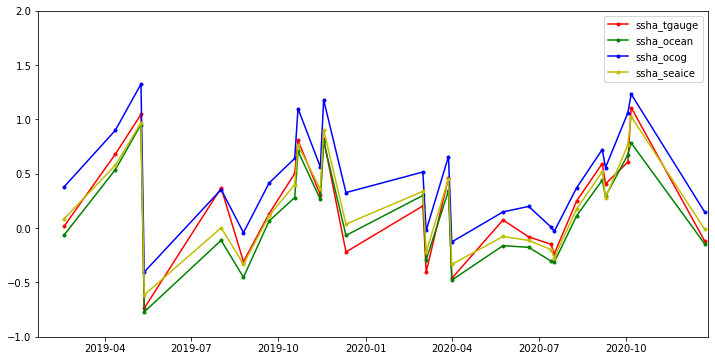

In [20]:
plt.figure(figsize=(12,6))
ssha_name =  'land_wf_ransac_pred'
plt.plot(result_final['time_20_ku'][ind_valid_tgauge], result_final['ssha_tgauge_interp'][ind_valid_tgauge],'r.-',label='ssha_tgauge')
plt.plot(result_final['time_20_ku'][ind_valid_tgauge], result_final['ssha_'+ssha_name+'_ocean'][ind_valid_tgauge],'g.-',label='ssha_ocean')
plt.plot(result_final['time_20_ku'][ind_valid_tgauge], result_final['ssha_'+ssha_name+'_ocog'][ind_valid_tgauge],'b.-',label='ssha_ocog')
plt.plot(result_final['time_20_ku'][ind_valid_tgauge], result_final['ssha_'+ssha_name+'_sea_ice'][ind_valid_tgauge],'y.-',label='ssha_seaice')
plt.axis([result_final['time_20_ku'][0], result_final['time_20_ku'][-1], -1, 7])
plt.axis([result_final['time_20_ku'][0],result_final['time_20_ku'][-1],-1,2])
plt.legend()


## Compare ransac prediction ssha and original ssha

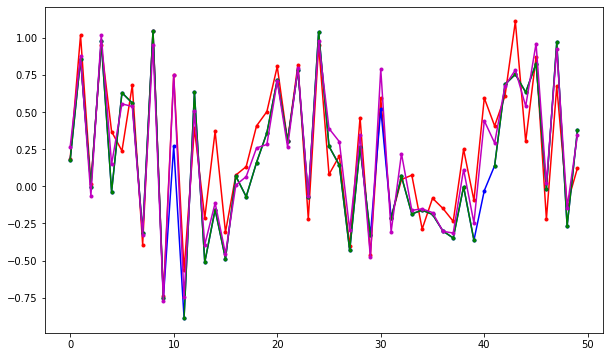

In [21]:
plt.figure(figsize=(10,6))
plt.plot(result_final['ssha_tgauge_interp'], 'r.-')
plt.plot(result_final['ssha_estimate_ocean'], 'b.-')
plt.plot(result_final['ssha_land_wf_ransac_filter_ocean'], 'g.-')
plt.plot(result_final['ssha_land_wf_ransac_pred_ocean'], 'm.-')


## Visualize the selected footprint 

In [8]:
result_final

<xarray.Dataset>
Dimensions:                                (echo_sample_ind: 128, lat_tgauge: 1, lon_tgauge: 1, time_20_ku: 50)
Coordinates:
  * time_20_ku                             (time_20_ku) datetime64[ns] 2019-0...
    lat_20_ku                              (time_20_ku) float64 ...
    lon_20_ku                              (time_20_ku) float64 ...
  * lon_tgauge                             (lon_tgauge) float32 114.2
  * lat_tgauge                             (lat_tgauge) float32 22.3
Dimensions without coordinates: echo_sample_ind
Data variables:
    UTC_day_20_ku                          (time_20_ku) datetime64[ns] ...
    UTC_sec_20_ku                          (time_20_ku) float64 ...
    UTC_time_1hz_20_ku                     (time_20_ku) datetime64[ns] ...
    lat_cor_20_ku                          (time_20_ku) float64 ...
    lon_cor_20_ku                          (time_20_ku) float64 ...
    surf_type_20_ku                        (time_20_ku) float32 ...
    surf_class_20_ku                       (time_20_ku) float32 ...
    dist_coast_20_ku                       (time_20_ku) float64 ...
    alt_20_ku                              (time_20_ku) float64 ...
    orb_alt_rate_20_ku                     (time_20_ku) float32 ...
    tracker_range_20_ku                    (time_20_ku) float64 ...
    h0_nav_dem_20_ku                       (time_20_ku) float64 ...
    agc_20_ku                              (time_20_ku) float32 ...
    agc_qual_20_ku                         (time_20_ku) float32 ...
    scale_factor_20_ku                     (time_20_ku) float64 ...
    range_ocean_20_ku                      (time_20_ku) float64 ...
    range_ocean_qual_20_ku                 (time_20_ku) float32 ...
    interpolated_c_band_range_ocean_20_ku  (time_20_ku) float64 ...
    sig0_ocean_20_ku                       (time_20_ku) float32 ...
    sig0_ocean_qual_20_ku                  (time_20_ku) float32 ...
    swh_ocean_20_ku                        (time_20_ku) float32 ...
    swh_ocean_qual_20_ku                   (time_20_ku) float32 ...
    epoch_ocean_20_ku                      (time_20_ku) float64 ...
    sigmac_ocean_20_ku                     (time_20_ku) float64 ...
    amplitude_ocean_20_ku                  (time_20_ku) float64 ...
    thermal_noise_ocean_20_ku              (time_20_ku) float64 ...
    off_nadir_angle_wf_ocean_20_ku         (time_20_ku) float32 ...
    number_of_iterations_ocean_20_ku       (time_20_ku) float32 ...
    mqe_ocean_20_ku                        (time_20_ku) float64 ...
    ssha_20_ku                             (time_20_ku) float32 ...
    range_ocog_20_ku                       (time_20_ku) float64 ...
    sig0_ocog_20_ku                        (time_20_ku) float32 ...
    range_ice_sheet_20_ku                  (time_20_ku) float64 ...
    sig0_ice_sheet_20_ku                   (time_20_ku) float32 ...
    elevation_ice_sheet_20_ku              (time_20_ku) float64 ...
    elevation_ocog_20_ku                   (time_20_ku) float64 ...
    range_ice_20_ku                        (time_20_ku) float64 ...
    sig0_ice_20_ku                         (time_20_ku) float32 ...
    sig0_leading_edge_ice_20_ku            (time_20_ku) float32 ...
    width_leading_edge_ice_20_ku           (time_20_ku) float32 ...
    slope_first_trailing_edge_ice_20_ku    (time_20_ku) float64 ...
    slope_second_trailing_edge_ice_20_ku   (time_20_ku) float64 ...
    range_sea_ice_20_ku                    (time_20_ku) float64 ...
    sig0_sea_ice_sheet_20_ku               (time_20_ku) float32 ...
    sea_ice_sea_surf_20_ku                 (time_20_ku) float64 ...
    sea_ice_ssha_20_ku                     (time_20_ku) float64 ...
    int_sea_ice_ssha_20_ku                 (time_20_ku) float64 ...
    freeboard_20_ku                        (time_20_ku) float64 ...
    surf_type_class_20_ku                  (time_20_ku) float32 ...
    uso_cor_20_ku                          (time_20_ku) float64 ...
    int_path_cor_20_ku  

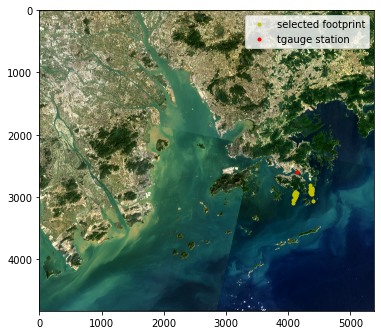

In [19]:
## get image coordinates (row,col).
col_fps, row_fps = geo2imagexy(lon=result_final['lon_20_ku'], lat=result_final['lat_20_ku'],img_gdal=img_gdal)
col_tgauge, row_tgauge = geo2imagexy(lon=result_final['lon_tgauge'], lat=result_final['lat_tgauge'],img_gdal=img_gdal)
plt.figure(figsize=(6,6))
imgShow(l8_img)
plt.plot(col_fps, row_fps, 'y.', label='selected footprint')
plt.plot(col_tgauge, row_tgauge, 'r.', label='tgauge station')
plt.legend()
